In [58]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import seaborn.objects as so
import numpy as np


# Define the path to the logs directory
logs_dir = '../logs/quirky'

# Walk through the directory

filters = {
    'rand_vs_nonrand': lambda root, dirs, files: 'eval.json' in files and 'probe_trajectory' in os.path.basename(root) and
     ('-rand_retrain' in os.path.basename(root) or 'nrand_retrain2' in os.path.basename(root) or '--' in os.path.basename(root)),
    'layerwise_activations': lambda root, dirs, files: 'eval.json' in files and len(os.path.basename(root).split('-')) > 4 and 'activations' in os.path.basename(root),
    'layerwise_agnostic': lambda root, dirs, files: 'eval.json' in files and len(os.path.basename(root).split('-')) > 4 and 
    ('activations' in root or '-probe-probe-' in root or 'misconception_contrast' in root or 'iterative_rephrase' in root or 'attribution' in root),
}
def get_data(filter, train_from_test=False):
    results = []
    for root, dirs, files in os.walk(logs_dir):
        if filter(root, dirs, files):
            # Load the main eval.json
            main_eval_path = os.path.join(root, 'eval.json')
            with open(main_eval_path, 'r') as f:
                main_eval = json.load(f)

            if '-que' in os.path.basename(root) and '-8' not in os.path.basename(root):
                continue

            if 'likelihood' in os.path.basename(root) and ('proj_oshrink' not in os.path.basename(root) and 'sentiment' not in os.path.basename(root)):
                continue
                
            if '-em-' in os.path.basename(root) and ('oshrink' not in os.path.basename(root) and 'sentiment' not in os.path.basename(root)):
                continue
            
            # Load the train_from_test eval.json
            if train_from_test:
                train_eval_path = os.path.join(root, 'train_from_test', 'eval.json')
                with open(train_eval_path, 'r') as f:
                    train_eval = json.load(f)
            # Extract dataset name from the folder structure    
            name_parts = os.path.basename(root).split('-')
            dataset = name_parts[0]
            score = name_parts[1]
            features = None
            name = None
            alpha = None
            layer = None
            if len(name_parts) > 2:
                features = name_parts[2]
            if len(name_parts) > 3:
                name = name_parts[3]
            if name_parts[-1].isdigit():
                alpha = int(name_parts[-1])
            rand = 0 if 'nrand' in os.path.basename(root) else 1
             
            if features == 'attribution':
                score = 'attribution-' + score

            # Append the results to the list
            if 'all' in main_eval:
                if len(name_parts) > 4:
                    layer = (int(name_parts[4]) + int(name_parts[5]))/2
                results.append({
                    'alpha': alpha,
                    'dataset': dataset,
                    'score': score,
                    'features': features,
                    'layer': layer,
                    'random_names': rand,
                    'auc_roc': main_eval['all']['AUC_ROC'],
                    'auc_roc_agree': main_eval['all']['AUC_ROC_AGREE'],
                    'auc_roc_disagree': main_eval['all']['AUC_ROC_DISAGREE'],
                })
            else:
                for key, value in main_eval.items():
                    layer = re.findall(r'\d+', key)[0]
                    results.append({
                        'alpha': alpha,
                        'dataset': dataset,
                        'score': score,
                        'features': features,
                        'layer': layer,
                        'random_names': rand,
                        'auc_roc': value['AUC_ROC'],
                        'auc_roc_agree': value['AUC_ROC_AGREE'],
                        'auc_roc_disagree': value['AUC_ROC_DISAGREE'],
                    })

    # Create a DataFrame from the results
    df = pd.DataFrame(results)

    # Order the datasets
    dataset_order = ['authors', 'population','capitals', 'nli', 'sciq', 'sentiment',  'hemisphere',  'addition', 'subtraction', 'multiplication', 'modularaddition', 'squaring']

    score_order = ['que', 'likelihood', 'em', 'lof', 'mahalanobis', 'attribution-mahalanobis', 'probe', 'rephrase', 'misconception']

    df['score'] = pd.Categorical(df['score'], categories=score_order, ordered=True)
    df['dataset'] = pd.Categorical(df['dataset'], categories=dataset_order, ordered=True)

    df = df.drop_duplicates(subset=['dataset', 'score', 'layer'])

    return df

def barplot_by_dataset(df, compare='random_names'):
    grouped_df = df.groupby(['dataset', compare])['auc_roc'].mean().reset_index()
    grouped_df = grouped_df.sort_values(by='dataset', ascending=True)
    # Create the barplot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='dataset', y='auc_roc', hue=compare, data=grouped_df)

    plt.title(f'Mean AUC-ROC by Dataset and {compare}')
    plt.xlabel('Dataset')
    plt.ylabel('Mean AUC-ROC')
    plt.legend(title=compare)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

metrics_dict = {
    'auc_roc_all': 'Alice vs Bob AUC',
    'auc_roc_agree': 'Alice vs Bob AUC (Agree)',
    'auc_roc_disagree': 'Alice vs Bob AUC (Disagree)',
    'auc_roc_train_from_test_all': 'Train names vs Test names AUC',
    'auc_roc_train_from_test_agree': 'Train names vs Test names AUC (Agree)',
    'auc_roc_train_from_test_disagree': 'Train names vs Test names AUC (Disagree)'
    }

def plot_auc_roc_by_layer_by_score(df, score_types=['que', 'likelihood', 'em', 'lof', 'mahalanobis', 'attribution-mahalanobis', 'probe destabilization', 'rephrase', 'misconception']):
    df['layer'] = df['layer'].astype(float)
    df = df[df['score'].isin(score_types)]
    
    layerwise_scores = df[df['layer'] >= 0]['score'].unique()
    single_scores = df[df['layer'] < 0]['score'].unique()
    df.loc[df['layer'] < 0, 'layer'] = 15

    n_rows = 3
    n_cols = 3
    f = plt.figure(figsize=(16, 16))
    subfigs = f.subfigures(n_rows, n_cols)
    
    y_min, y_max = df['auc_roc'].min(), df['auc_roc'].max()
    y_range = y_max - y_min
    y_padding = y_range * 0.1  # 10% padding
    
    for idx, score in enumerate(score_types):
        row = idx // n_cols
        col = idx % n_cols
        
        ax = subfigs[row, col].subplots()
        if score in layerwise_scores:
            score_df = df[(df['score'] == score)]
            (
                so.Plot(score_df, x="layer", y="auc_roc", color="dataset", marker="dataset")
                .add(so.Line(), so.Agg())
                .add(so.Dot(), so.Jitter(x=0.2))
                .label(title=score, x="Layer", y="Alice vs Bob AUC")
                .limit(x=(14, None), y=(y_min - y_padding, y_max + y_padding))
                .on(ax)
                .plot()
            )
        elif score in single_scores:
            score_df = df[(df['score'] == score)]
            (
                so.Plot(score_df, x="dataset", y="auc_roc", color="dataset")
                .add(so.Bar())
                .add(so.Dot(), so.Jitter(x=0.2))
                .label(title=score, y="Alice vs Bob AUC")
                .limit(y=(y_min - y_padding, y_max + y_padding))
                .on(ax)
                .plot()
            )
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)

    plt.subplots_adjust(hspace=4, wspace=0.3)  # Adjust these values as needed
    plt.tight_layout()
    return f



/tmp/ipykernel_576225/904001881.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['dataset', compare])['auc_roc'].mean().reset_index()


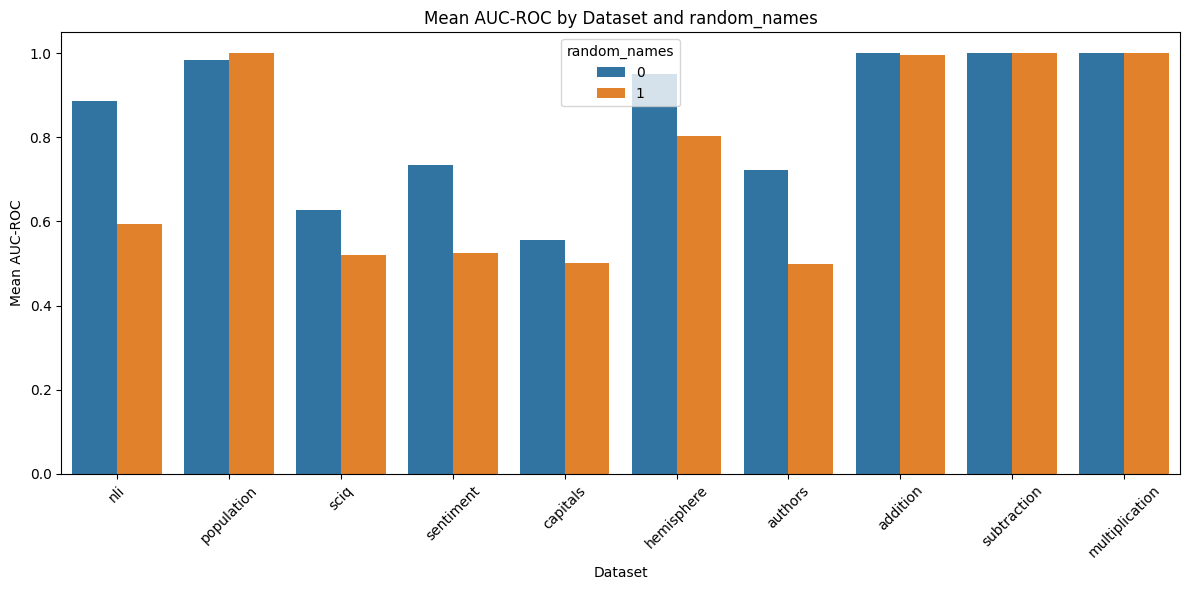

In [82]:
df = get_data(filters['rand_vs_nonrand'])
barplot_by_dataset(df[~df['dataset'].isin(['modularaddition', 'squaring'])], compare='random_names')

/tmp/ipykernel_1044106/1732270367.py:179: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1044106/1732270367.py:179: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1044106/1732270367.py:179: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1044106/1732270367.py:179: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


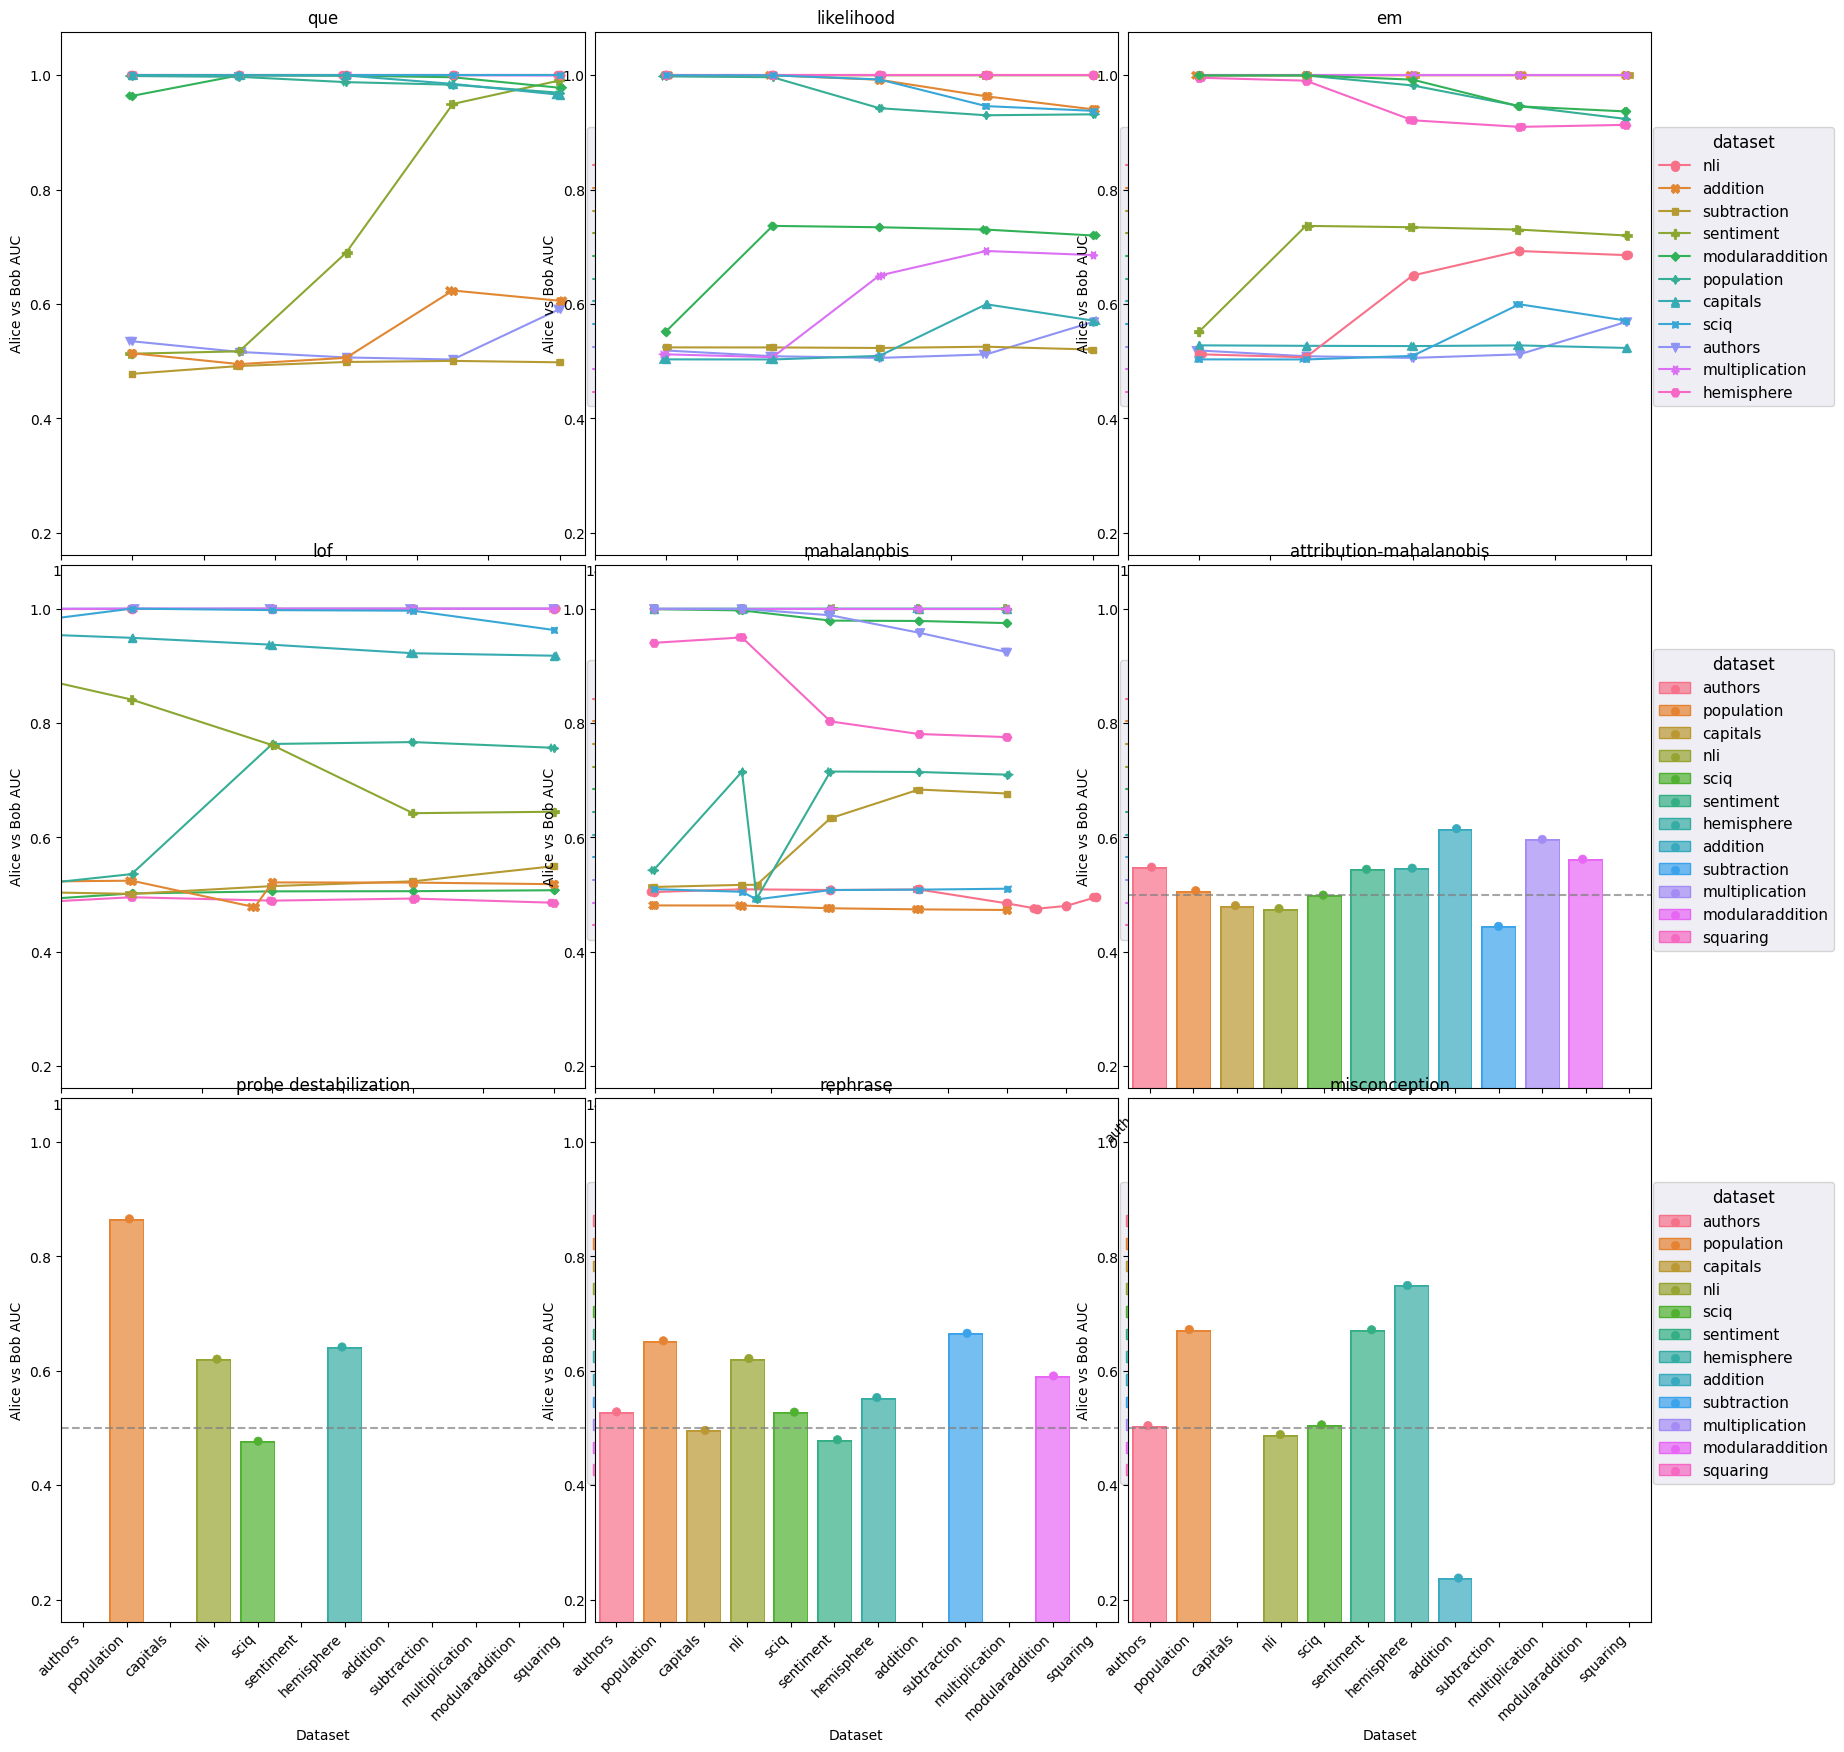

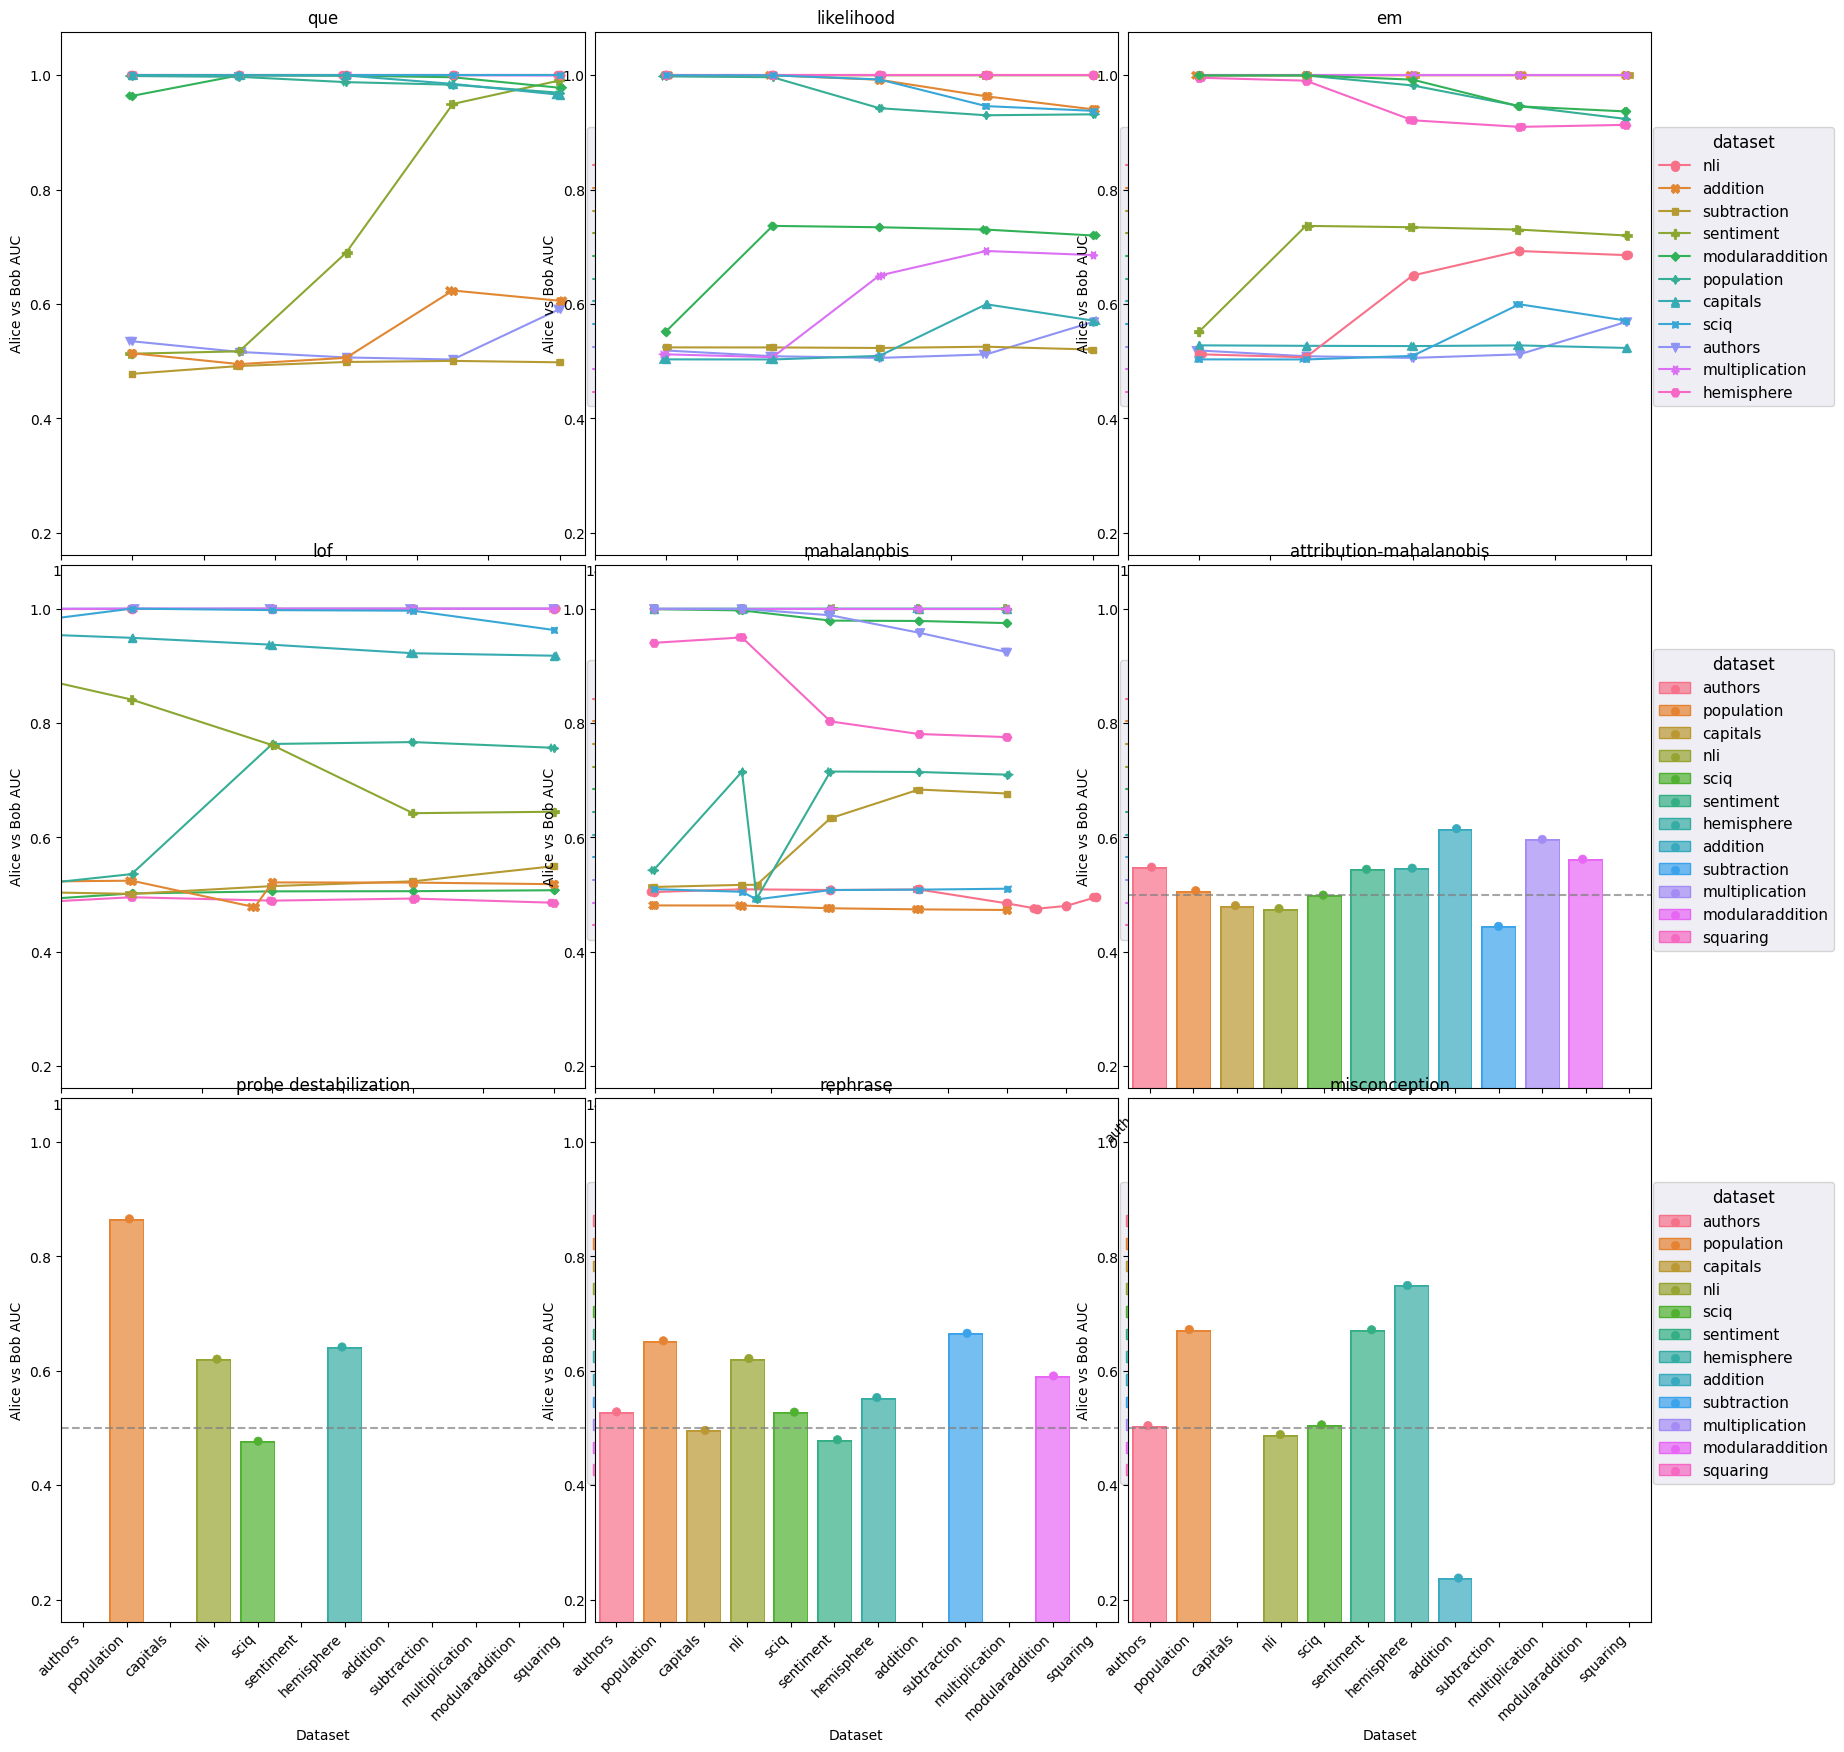

In [59]:
df = get_data(filters['layerwise_agnostic'])
df.loc[df['score'].isin(['rephrase', 'misconception', 'probe', 'attribution-mahalanobis']), 'layer'] = -1
df['score'] = df['score'].cat.add_categories('probe destabilization')
df.loc[df['score'] == 'probe', 'score'] = 'probe destabilization'
df['score'] = df['score'].cat.remove_unused_categories()

plot_auc_roc_by_layer_by_score(df)

In [54]:
df[df['score']=='attribution-mahalanobis']

,alpha,dataset,score,features,layer,random_names,auc_roc,auc_roc_agree,auc_roc_disagree
34,NaN,population,attribution-mahalanobis,attribution,22.0,1,0.506894,0.502520,0.518924
41,NaN,sciq,attribution-mahalanobis,attribution,22.0,1,0.499138,0.520691,0.445976
98,NaN,sentiment,attribution-mahalanobis,attribution,22.0,1,0.544291,0.542594,0.544484
117,NaN,capitals,attribution-mahalanobis,attribution,22.0,1,0.480746,0.480768,0.472007
119,NaN,modularaddition,attribution-mahalanobis,attribution,22.0,1,0.561944,0.536022,0.588137
159,NaN,nli,attribution-mahalanobis,attribution,22.0,1,0.475587,0.384538,0.637856
191,NaN,authors,attribution-mahalanobis,attribution,22.0,1,0.547986,0.540119,0.566468
193,NaN,multiplication,attribution-mahalanobis,attribution,22.0,1,0.596551,0.677831,0.527786
236,NaN,hemisphere,attribution-mahalanobis,attribution,22.0,1,0.546279,0.473348,0.685228
310,NaN,addition,attribution-mahalanobis,attribution,22.0,1,0.615322,0.867199,0.376298
